In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.options.display.max_columns =40

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

import warnings
warnings.filterwarnings('ignore')


In [2]:
receipts_disposal = pd.read_csv("E:\\The Institution\\DARPG Hackathon\\DataSet-MonthwiseReceiptsDisposal_1.csv")
print("receipts_disposal: ", receipts_disposal.shape)

receipts_disposal:  (5567, 5)


In [3]:
receipts_disposal.head()

,org_name,Year,Month,Recetpts,Disposals
0,Central Board of Direct Taxes (Income Tax),2016,1,1600,49
1,Central Board of Direct Taxes (Income Tax),2016,2,2106,207
2,Central Board of Direct Taxes (Income Tax),2016,3,2465,2702
3,Central Board of Direct Taxes (Income Tax),2016,4,1912,1320
4,Central Board of Direct Taxes (Income Tax),2016,5,2797,1588


In [4]:
receipts_disposal = receipts_disposal.rename(columns={"Recetpts":"Receipts"})

In [5]:
receipts_disposal.head()

,org_name,Year,Month,Receipts,Disposals
0,Central Board of Direct Taxes (Income Tax),2016,1,1600,49
1,Central Board of Direct Taxes (Income Tax),2016,2,2106,207
2,Central Board of Direct Taxes (Income Tax),2016,3,2465,2702
3,Central Board of Direct Taxes (Income Tax),2016,4,1912,1320
4,Central Board of Direct Taxes (Income Tax),2016,5,2797,1588


In [6]:
receipts_disposal["Date"] = pd.to_datetime(receipts_disposal["Year"].astype(str) + "-" + receipts_disposal["Month"].astype(str), format = "%Y-%d")

In [7]:
print(receipts_disposal.dtypes)
receipts_disposal = receipts_disposal.drop(["Year", "Month"],axis=1)
receipts_disposal.head()


org_name             object
Year                  int64
Month                 int64
Receipts              int64
Disposals             int64
Date         datetime64[ns]
dtype: object


,org_name,Receipts,Disposals,Date
0,Central Board of Direct Taxes (Income Tax),1600,49,2016-01-01
1,Central Board of Direct Taxes (Income Tax),2106,207,2016-01-02
2,Central Board of Direct Taxes (Income Tax),2465,2702,2016-01-03
3,Central Board of Direct Taxes (Income Tax),1912,1320,2016-01-04
4,Central Board of Direct Taxes (Income Tax),2797,1588,2016-01-05


In [8]:
org_counts = receipts_disposal['org_name'].value_counts()
org_list = org_counts[org_counts == 47].index.tolist()

print(org_list, len(org_list))

['Legislative Department', 'Department of Youth Affairs', 'Government of Gujarat', 'O/o the Comptroller & Auditor General of India', 'Ministry of Petroleum and Natural Gas', 'Ministry of Power', 'Department of Heavy Industry', 'Department of Defence Production', 'Government of Bihar', 'Ministry of Home Affairs', 'Ministry of Road Transport and Highways', 'Ministry of Corporate Affairs', 'Department of Investment & Public Asset Management', 'Department of Financial Services (Insurance Division)', 'Government of Uttar Pradesh', 'Department of Defence Finance', 'Department of Industrial Policy & Promotion', 'Department of Justice', 'Department of Scientific & Industrial Research', 'Ministry  of Coal', 'Ministry of Ayush', 'Department of Personnel and Training', 'Ministry of Skill Development and Entrepreneurship', 'Government of Kerala', 'Department of Health & Family Welfare', 'Ministry of Information and Broadcasting', 'Ministry of Culture', 'Department of Defence', 'Ministry of Women a

In [9]:
receipts_disposal = receipts_disposal[receipts_disposal['org_name'].isin(org_list)]

In [10]:
min_externalaffairs = receipts_disposal[receipts_disposal["org_name"]=="Ministry of External Affairs"]

In [11]:
min_externalaffairs_receipts = min_externalaffairs.drop(["Disposals","org_name"],axis=1)
min_externalaffairs_receipts = min_externalaffairs_receipts.set_index("Date")


In [12]:
print(min_externalaffairs.shape)
min_externalaffairs.head()

(47, 4)


,org_name,Receipts,Disposals,Date
4215,Ministry of External Affairs,770,360,2016-01-01
4216,Ministry of External Affairs,862,958,2016-01-02
4217,Ministry of External Affairs,984,913,2016-01-03
4218,Ministry of External Affairs,1034,1098,2016-01-04
4219,Ministry of External Affairs,943,943,2016-01-05


In [13]:
min_externalaffairs_receipts = min_externalaffairs.drop(["Disposals","org_name"],axis=1)
min_externalaffairs_receipts = min_externalaffairs_receipts.set_index("Date")

In [14]:
min_externalaffairs_receipts.head()

,Receipts
Date,
2016-01-01,770
2016-01-02,862
2016-01-03,984
2016-01-04,1034
2016-01-05,943


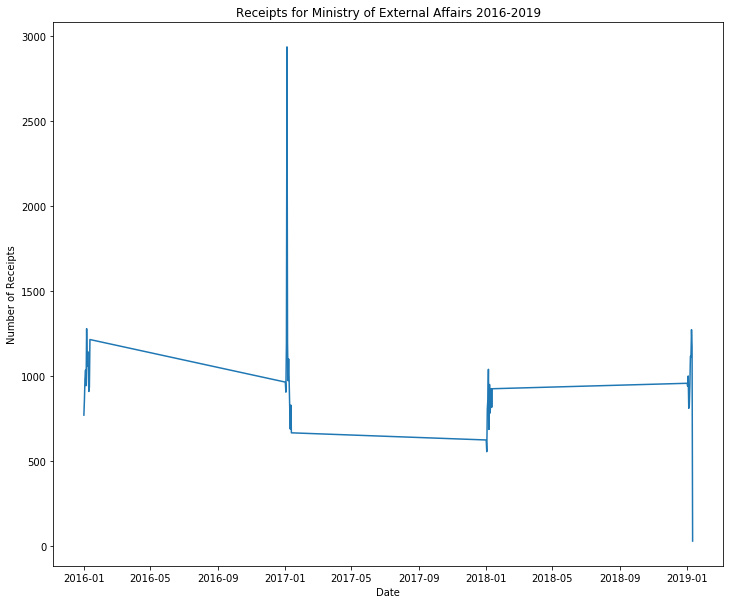

In [15]:
plt.figure(figsize=(12,10))
plt.plot(min_externalaffairs_receipts)
plt.title("Receipts for Ministry of External Affairs 2016-2019")
plt.xlabel("Date")
plt.ylabel("Number of Receipts")
plt.show()

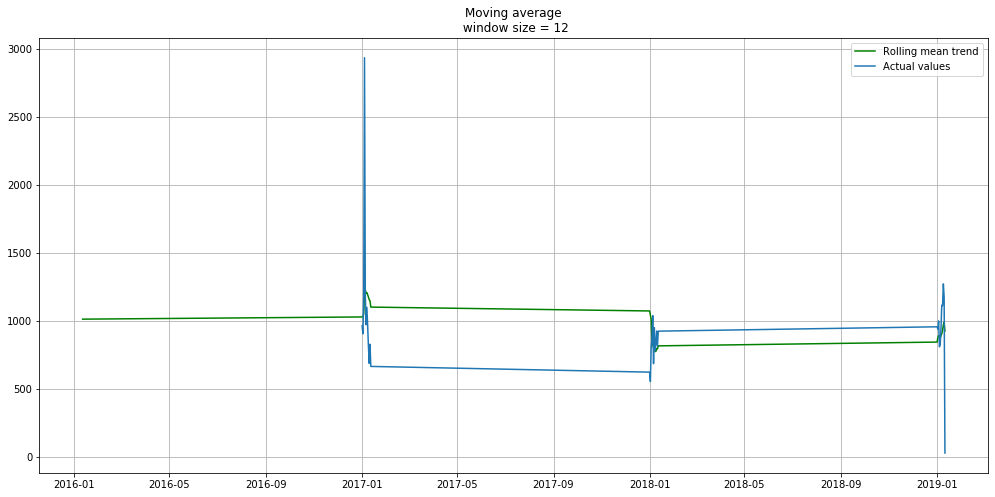

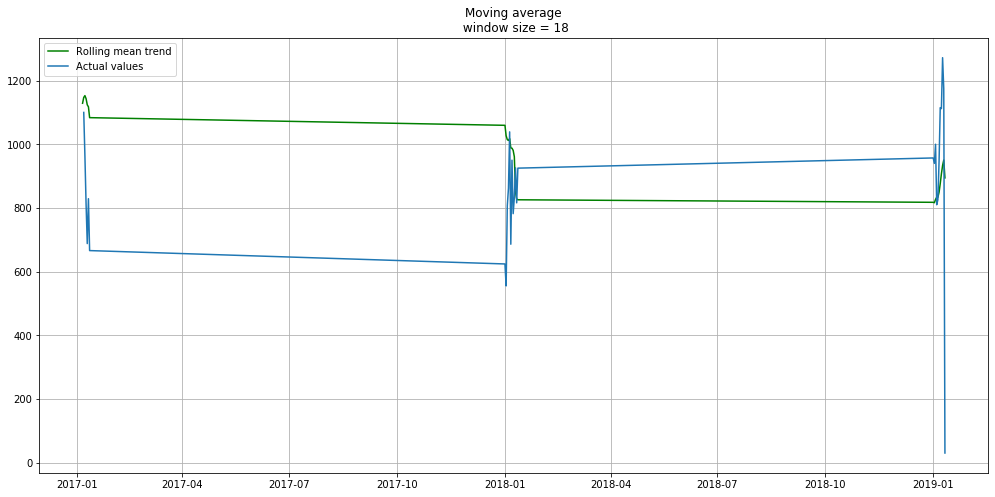

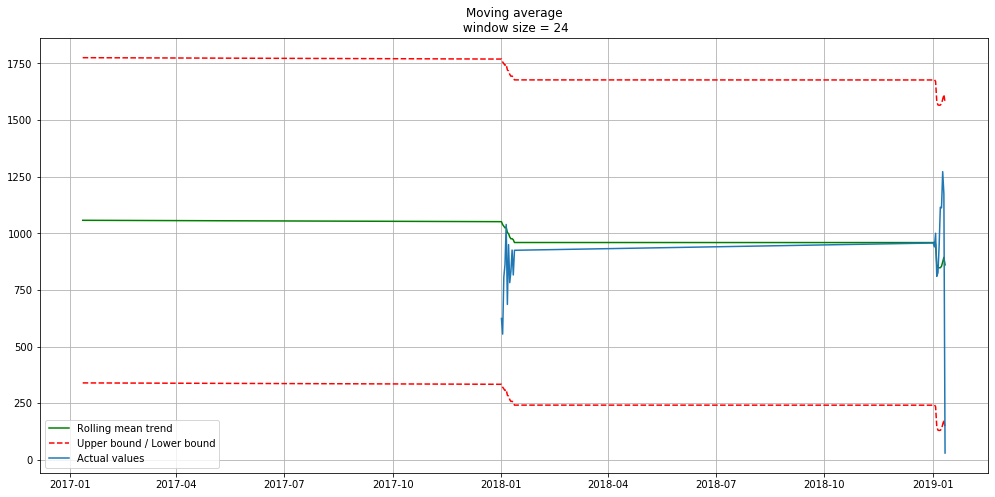

In [16]:
#moving average method
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)
    
#Smooth by the previous 12 months  
plot_moving_average(min_externalaffairs_receipts.Receipts, 12)

#Smooth by the previous 18 months
plot_moving_average(min_externalaffairs_receipts.Receipts, 18)

#Smooth by previous 24 months
plot_moving_average(min_externalaffairs_receipts.Receipts, 24, plot_intervals=True)

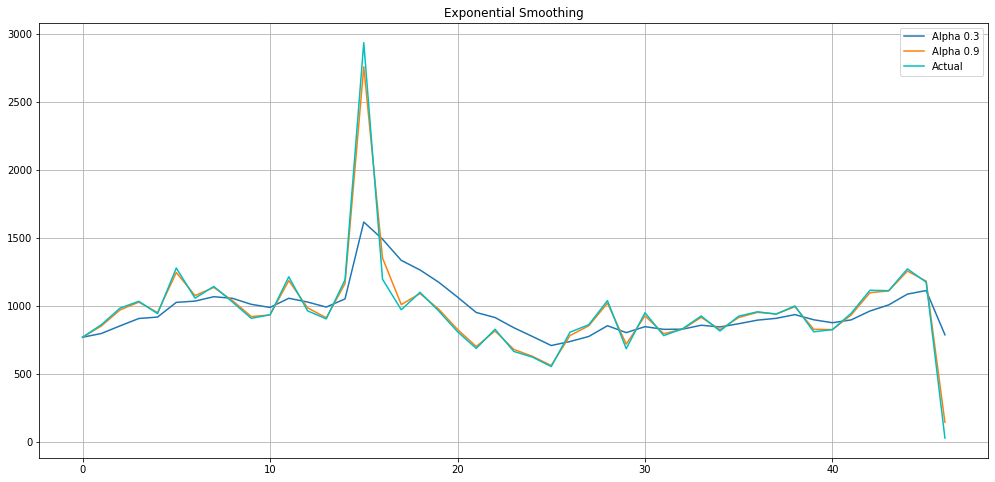

In [17]:
#exponential smoothing
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
  
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

plot_exponential_smoothing(min_externalaffairs_receipts.Receipts, [0.3, 0.9])

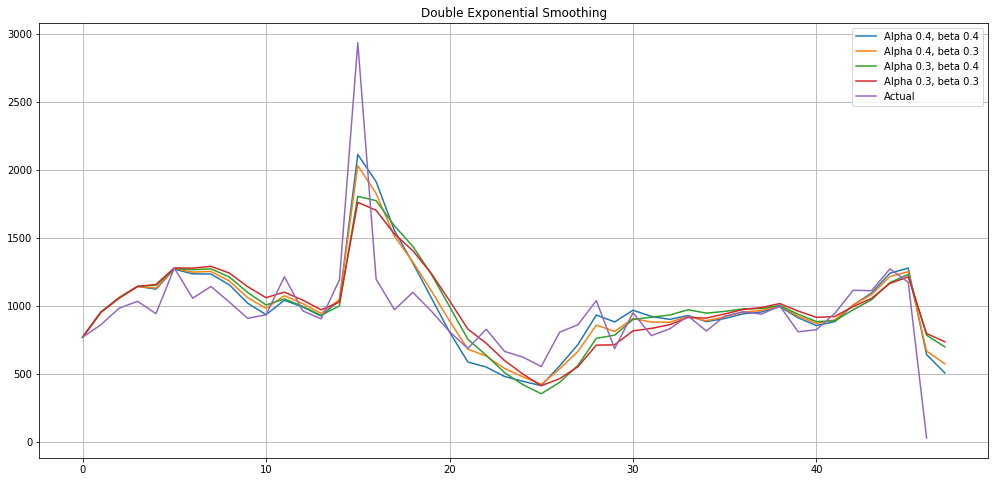

In [19]:
#Double Exponential Smoothing
def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
     
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)
    
plot_double_exponential_smoothing(min_externalaffairs_receipts.Receipts, alphas=[0.4, 0.3], betas=[0.4, 0.3])

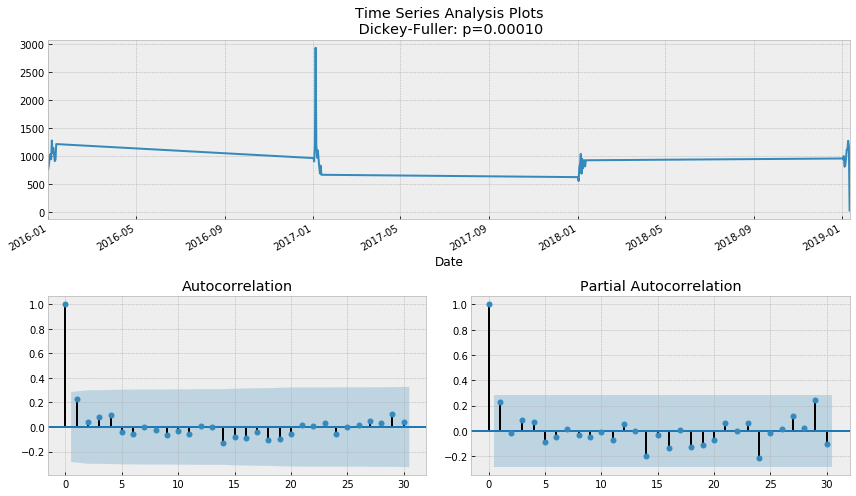

In [20]:
#Dickey Fuller Test
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(min_externalaffairs_receipts.Receipts, lags=30)

# Take the first difference to remove to make the process stationary
#diff1 = min_externalaffairs_receipts.Receipts - min_externalaffairs_receipts.Receipts.shift(6)
#diff1.dropna(inplace=True)
#tsplot(diff1[1:], lags=30)


In [21]:
#SARIMA
#Set initial values and some bounds
ps = range(0, 5)
d = 1
qs = range(0, 5)
Ps = range(0, 5)
D = 1
Qs = range(0, 5)
s = 5

#Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Train many SARIMA models to find the best set of parameters
def optimize_SARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """
    
    results = []
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(min_externalaffairs_receipts.Receipts, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        
        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s)

#Set parameters that give the lowest AIC (Akaike Information Criteria)
p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(min_externalaffairs_receipts.Receipts, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())


                                 Statespace Model Results                                
Dep. Variable:                          Receipts   No. Observations:                   47
Model:             SARIMAX(0, 1, 2)x(0, 1, 1, 5)   Log Likelihood                -306.200
Date:                           Sun, 05 Jan 2020   AIC                            620.400
Time:                                   09:44:52   BIC                            627.254
Sample:                                        0   HQIC                           622.896
                                            - 47                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6346      1.321     -0.480      0.631      -3.225       1.955
ma.L2         -0.3518      0.540     -0.65

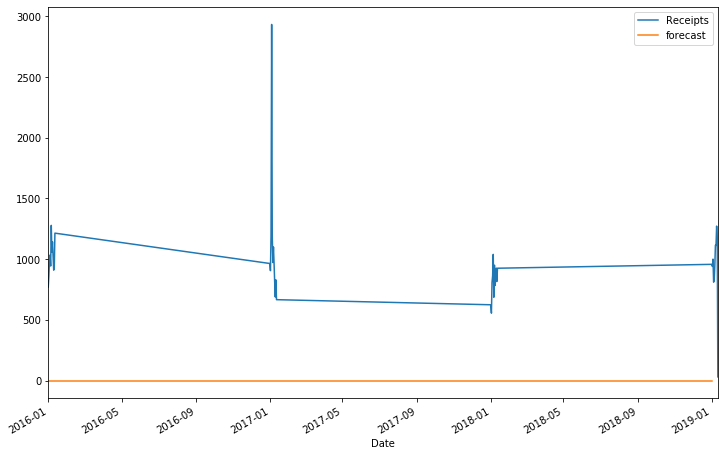

In [28]:
min_externalaffairs_receipts['forecast'] = best_model.predict(start = "2016-01", end= "2019-01", dynamic= True)  
min_externalaffairs_receipts[['Receipts', 'forecast']].plot(figsize=(12, 8))
plt.show()

In [29]:
#future forecasts
def forcasting_future_months(df, no_of_months):
    min_externalaffairs_receipts_predict = min_externalaffairs_receipts.reset_index()
    mon = min_externalaffairs_receipts_predict['Date']
    mon = mon + pd.DateOffset(months = no_of_months)
    future_dates = mon[-no_of_months -1:]
    min_externalaffairs_receipts_predict = min_externalaffairs_receipts_predict.set_index('Date')
    future = pd.DataFrame(index=future_dates, columns= min_externalaffairs_receipts_predict.columns)
    min_externalaffairs_receipts_predict = pd.concat([min_externalaffairs_receipts_predict, future])
    min_externalaffairs_receipts_predict['forecast'] = best_model.predict(start = "2018-01", end = "2019-01", dynamic= True)  
    min_externalaffairs_receipts_predict[['Receipts', 'forecast']].plot(figsize=(12, 8))
    plt.show()
    return min_externalaffairs_receipts_predict[-no_of_months:]

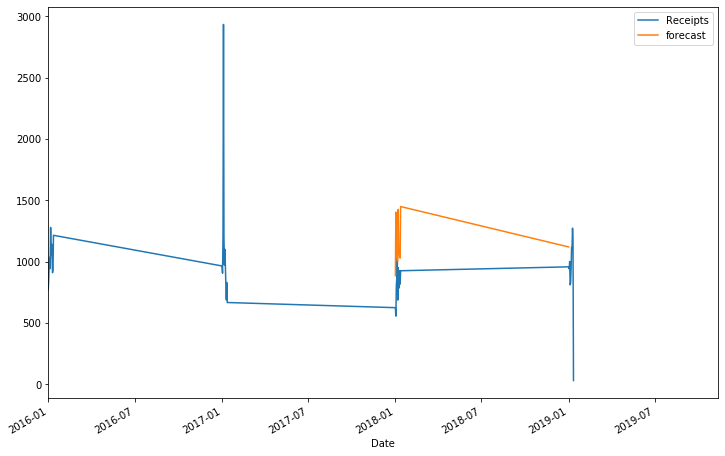

In [30]:
predicted = forcasting_future_months(min_externalaffairs_receipts,10)

In [34]:
yhat = best_model.forecast()

In [39]:
yhat2 = best_model.predict(start = "2016-01", end = "2019-01")
yhat2

Date
2016-01-01       0.000000
2016-01-02     737.026023
2016-01-03     824.191906
2016-01-04     977.859370
2016-01-05    1040.714299
2016-01-06    1331.154708
2016-01-07    1386.352422
2016-01-08    1273.586668
2016-01-09    1306.243286
2016-01-10    1049.558350
2016-01-11    1307.028097
2016-01-12    1039.819486
2017-01-01    1321.869473
2017-01-02    1036.900481
2017-01-03     938.753312
2017-01-04    1263.480632
2017-01-05    2176.965189
2017-01-06    1196.287462
2017-01-07    1333.699727
2017-01-08    1268.274457
2017-01-09    1776.254469
2017-01-10     997.683971
2017-01-11    1067.117843
2017-01-12    1044.751012
2018-01-01     885.054298
2018-01-02    1278.692477
2018-01-03     683.614814
2018-01-04     937.491561
2018-01-05     826.544080
2018-01-06     890.620219
2018-01-07    1040.556152
2018-01-08     828.319172
2018-01-09     823.199570
2018-01-10     839.198180
2018-01-11     770.742410
2018-01-12    1065.236701
2019-01-01     762.605806
dtype: float64

No handles with labels found to put in legend.


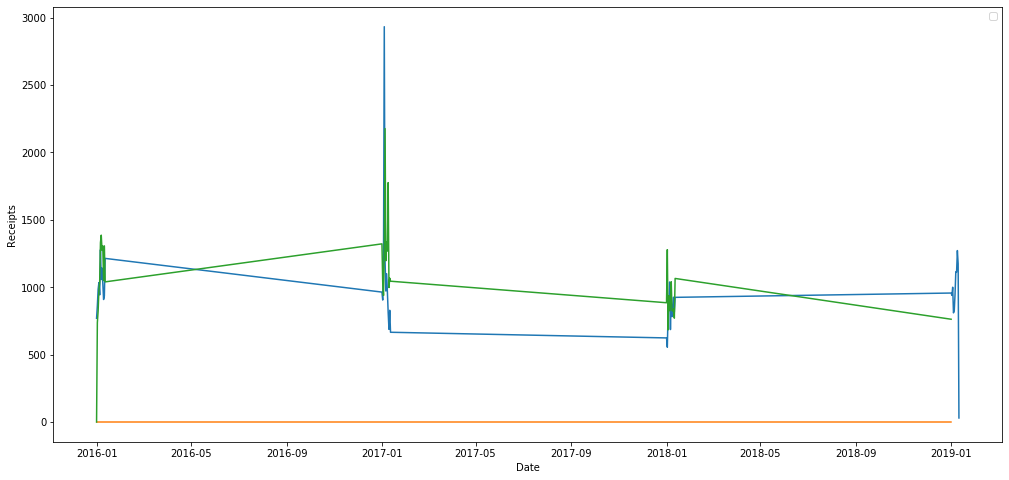

In [40]:
#Plot predicted vs actual 

plt.figure(figsize=(17, 8))
plt.plot(min_externalaffairs_receipts)
plt.plot(yhat2)
#plt.title('Predicted closing price of New Germany Fund Inc (GF)')
plt.ylabel('Receipts')
plt.xlabel('Date')
plt.legend(loc='best')
plt.grid(False)
plt.show()